In [1]:
#Based on tutorial: https://machinelearningmastery.com/random-forest-ensemble-in-python/
#Run this code before you can classify

# Use numpy to convert to arrays
import numpy as np
from numpy import mean, std

# Pandas is used for data manipulation
import pandas as pd

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

def buildModel(features, labelDimension) :
    # Labels are the values we want to predict
    labels = np.array(features[labelDimension])
    # Remove the labels from the features
    # axis 1 refers to the columns
    features= features.drop(labelDimension, axis = 1)

    # Convert to numpy array
    features = np.array(features)

    # Split the data into training and testing sets (heavily overfit on provided dataset to get as close as possible to the original model)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.30)

    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_labels.shape)

    # Instantiate model with 1000 decision trees
    rf = RandomForestClassifier(n_estimators = 1500)
    # Train the model on training data
    rf.fit(train_features, train_labels)

    #evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1)
    n_scores = cross_val_score(rf, features, labels, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

    print("done!")
    print("evaluating:")

    # report performance
    print(n_scores)
    print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

    return rf

In [31]:
#load in the dataset
features = pd.read_csv('heloc_dataset_v1.csv')
features.replace([-9, -8, -7], np.nan, inplace=True)
#the columns that stores the labels
labelDimension = "RiskPerformance"

In [74]:
categorical = ['MaxDelqEver', 'MaxDelq/PublicRecLast12M']
X = features[features.columns[1:]]
y = features[labelDimension]
for cat in categorical:
    X[cat] = X[cat].astype("category")

C:\Users\adubo\AppData\Local\Temp\ipykernel_32480\176215948.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")
C:\Users\adubo\AppData\Local\Temp\ipykernel_32480\176215948.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")


In [6]:
y_code = y.astype("category").cat.codes

In [34]:
numerical = [col for col in X.columns if col not in categorical]

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

model = RandomForestClassifier(n_estimators = 1500)

num_pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder())
transform = ColumnTransformer(transformers=[('num', num_pipe, numerical), ('cat', cat_pipe, categorical)])
model_pipe = Pipeline(steps=[('preprocess', transform), ('model', model)]).fit(X, y)

In [52]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(model_pipe, X, y, cv=4, n_jobs=-1)

In [83]:
labelled_correctly = y_pred == y

In [63]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

X_embed = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

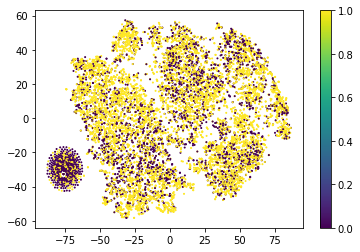

In [66]:
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=labelled_correctly, s=1)
plt.colorbar()

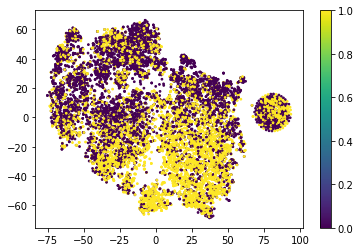

In [62]:
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=y_code.tolist(), s=3)
plt.colorbar()

In [102]:
from sklearn.decomposition import PCA
import plotly.express as px


X_transform = transform.fit_transform(X)
pca = PCA()
components = pca.fit_transform(X_transform)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=labelled_correctly
)
fig.update_traces(diagonal_visible=True)
fig.show()

In [104]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_transform)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=labelled_correctly)

for i, dim in enumerate(X.columns.tolist()):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=dim,
    )
fig.show()